#### code up here to be put into separate file

In [12]:
def map_with_bins(column, df, quantiles=False):
    """Takes a column from a df, determines what bin each row lies
    in, then plots on a map with the color dependent on the bin"""
    
    bin_cutoffs=5
    color_lst=['#2c7bb6', '#abd9e9', '#ffffbf', '#fdae61', '#d7191c']
    
    if quantiles:
        bins = pd.qcut(df[column], bin_cutoffs)
    else:
        bins = pd.cut(df[column], bin_cutoffs)
    bin_names = bins.cat.categories
      
    bin_to_color = dict(zip(bin_names, color_lst))   
    bin_display = pd.DataFrame(bin_names, columns=['Bins'])
    display(bin_display.style.applymap(lambda x: 'background-color: {}'.format(bin_to_color[x])))

    mapper = folium.Map(zoom_start=8)
    for lat, lon , bn in list(zip(df['Latitude'], df['Longitude'], bins)):
        folium.Circle(
            radius=300,
            location=[lat, lon],
            color=bin_to_color[bn],
            fill=False).add_to(mapper)
    return mapper

In [23]:
def overlay_hex(x_values, y_values):
    """Overlays a regression line on top of a hex plot
    Works well when dealing with a large number of observations"""
    g = sns.jointplot(x_values, y_values, kind="hex")
    sns.regplot(x_values, y_values, ax=g.ax_joint, scatter=False)

In [126]:
def drop_and_subset(column, df, desired):
    lst = desired.copy()
    lst.append(column)
    intermediate = combined.dropna(subset=[column])
    return intermediate[lst].copy()

# [COGSCI 1B] Typology
---
### Professor Terry Regier

This module explores a central question in cognitive science and linguistics: how do languages vary from one another? We will explore datasets of linguistic features (WALS and Phoible) to come to tentative answers to this question in a data-driven way. Example problems include visualizing the distribution of phonemes, the relationship between geography and the development of languages, and the genetic relationships of languages.

---

### Table of Contents

0 - [The Data](#section data)

1 - [Phoneme Distributions](#phoneme dist)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.1 - [Consonants](#consonants)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.2 - [Vowels](#vowels)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.3 - [Phonemes](#phonemes)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.4 - [Consonants vs Vowels](#cons vs vows)<br>

2 - [Phonemes Metadata](#metadata)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.1 - [Family](#phoneme fam)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.2 - [Continent](#phoneme cont)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.3 - [Latitude and Longitude](#lat lons)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.4 - [Population Size vs Phoneme Inventory Size](#pop v foam)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.5 - [Distance from Africa](#africa distance)

3 - [Common Phonemes](#common)

4 - [Tone](#tone)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 4.1 - [Altitude](#altitude)

5 - [Morphological Complexity](#morph complex)

**Dependencies:**

In [156]:
# currently running into problems when running folium 
# on datahub -- you have to pip upgrade, then restart

#!pip install -U folium

In [1]:
import folium
import numpy as np
import pandas as pd
import seaborn as sns
import geopy.distance
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import display
import warnings

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
%matplotlib inline

## The Data <a id='section data'></a>

In [2]:
phoible_data = pd.read_csv('phoible_elevation.csv')
phoible_data.head()

InventoryID Source LanguageCode LanguageName Glottocode     GlottologName  \
0            1    SPA          kor       Korean   kore1280            Korean   
1            2    SPA          ket          Ket   kett1243               Ket   
2            3    SPA          lbe          Lak   lakk1252               Lak   
3            4    SPA          kbd    Kabardian   kaba1278         Kabardian   
4            5    SPA          kat     Georgian   nucl1302  Nuclear Georgian   

   Trump LanguageFamilyRoot  LanguageFamilyGenus             Country    Area  \
0      1               asis               Korean        Korea, South    Asia   
1      1               yeos            Yeniseian  Russian Federation  Europe   
2      1               ncau           Lak-Dargwa  Russian Federation  Europe   
3      1               ncau  Northwest Caucasian  Russian Federation  Europe   
4      1               kart           Kartvelian             Georgia    Asia   

  Population  Latitude  Longitude  Phonemes  Consonants  Tones  Vowels  \
0   42000000   37.5000   128.0000        40          22      0      18   
1        190   63.7551    87.5466        32          18      0      14   
2     157000   42.1328    47.0809        69          60      0       9   
3     520000   43.5082    43.3918        56          49      0       7   
4    3900000   39.3705    45.8066        35          29      0       6   

     elevation  
0   330.066681  
1    25.690624  
2  2169.640625  
3   943.938354  
4  2204.326416

In [39]:
#Recreated for convenience and Converted Population column to numerical values
#phoib now only has rows who's population column value was a number

phoib = phoible_data[phoible_data["Population"].apply(lambda x: str(x).isdigit())]
phoib["Population"] = [int(i) for i in phoib["Population"]]

# stands for good phoib / use for mapping
phoib_mapping = phoib.dropna()

phoib.head()

InventoryID Source LanguageCode LanguageName Glottocode     GlottologName  \
0            1    SPA          kor       Korean   kore1280            Korean   
1            2    SPA          ket          Ket   kett1243               Ket   
2            3    SPA          lbe          Lak   lakk1252               Lak   
3            4    SPA          kbd    Kabardian   kaba1278         Kabardian   
4            5    SPA          kat     Georgian   nucl1302  Nuclear Georgian   

   Trump LanguageFamilyRoot  LanguageFamilyGenus             Country    Area  \
0      1               asis               Korean        Korea, South    Asia   
1      1               yeos            Yeniseian  Russian Federation  Europe   
2      1               ncau           Lak-Dargwa  Russian Federation  Europe   
3      1               ncau  Northwest Caucasian  Russian Federation  Europe   
4      1               kart           Kartvelian             Georgia    Asia   

   Population  Latitude  Longitude  Phonemes  Consonants  Tones  Vowels  \
0    42000000   37.5000   128.0000        40          22      0      18   
1         190   63.7551    87.5466        32          18      0      14   
2      157000   42.1328    47.0809        69          60      0       9   
3      520000   43.5082    43.3918        56          49      0       7   
4     3900000   39.3705    45.8066        35          29      0       6   

     elevation  
0   330.066681  
1    25.690624  
2  2169.640625  
3   943.938354  
4  2204.326416

In [ ]:
wals = pd.read_csv('wals_data/language.csv')
wals.head()

In [ ]:
# multiple rows for some of these Language Codes
sum(pd.DataFrame.from_dict(Counter(
    phoible_data['LanguageCode']), orient='index').reset_index().sort_values(0, ascending=False)[0] > 1)

In [6]:
len(list(set(phoible_data['LanguageCode'])))

1672

In [7]:
# same language code, but different language name? What is `Trump`?
cond = np.logical_and(phoible_data['Source'] == 'GM', phoible_data['LanguageCode'] == 'sgw')
phoible_data[cond]

InventoryID Source LanguageCode LanguageName Glottocode  \
1458         1459     GM          sgw        Muher   seba1251   
1459         1460     GM          sgw         Ezha   seba1251   
1460         1461     GM          sgw        Chaha   seba1251   
1461         1462     GM          sgw        Gumer   seba1251   
1462         1463     GM          sgw         Gura   seba1251   
1463         1464     GM          sgw        Gyeto   seba1251   

         GlottologName  Trump LanguageFamilyRoot LanguageFamilyGenus  \
1458  Sebat Bet Gurage      1               afas             Semitic   
1459  Sebat Bet Gurage      2               afas             Semitic   
1460  Sebat Bet Gurage      3               afas             Semitic   
1461  Sebat Bet Gurage      4               afas             Semitic   
1462  Sebat Bet Gurage      5               afas             Semitic   
1463  Sebat Bet Gurage      6               afas             Semitic   

       Country    Area Population  Latitude  Longitude  Phonemes  Consonants  \
1458  Ethiopia  Africa    2320000   8.11879    37.9891        42          34   
1459  Ethiopia  Africa    2320000   8.11879    37.9891        39          33   
1460  Ethiopia  Africa    2320000   8.11879    37.9891        44          36   
1461  Ethiopia  Africa    2320000   8.11879    37.9891        42          35   
1462  Ethiopia  Africa    2320000   8.11879    37.9891        42          36   
1463  Ethiopia  Africa    2320000   8.11879    37.9891        45          39   

      Tones  Vowels    elevation  
1458      0       8  2262.824463  
1459      0       6  2262.824463  
1460      0       8  2262.824463  
1461      0       7  2262.824463  
1462      0       6  2262.824463  
1463      0       6  2262.824463

In [8]:
sum(pd.DataFrame.from_dict(Counter(
    phoible_data['LanguageCode']), orient='index').reset_index().sort_values(0, ascending=False)[0] > 1)

377

In [9]:
mp = folium.Map(zoom_start=12)
phoib_coords = phoib.dropna(subset=['Latitude', 'Longitude'])
for coords in list(zip(phoib_coords['Latitude'], phoib_coords['Longitude'])):
    folium.Circle(
        radius=100,
        location=coords,
        color='crimson',
        fill=False,).add_to(mp)
mp

In [10]:
combined = wals.dropna(subset=['iso_code']).merge(phoib.dropna(), left_on='iso_code', right_on='LanguageCode', how='inner')
combined.head()

wals_code iso_code glottocode     Name   latitude   longitude         genus  \
0       aar      aiw   aari1239     Aari   6.000000   36.583333  South Omotic   
1       aba      aau   abau1245     Abau  -4.000000  141.250000   Upper Sepik   
2       abd      abi   abid1235   Abidji   5.666667   -4.583333           Kwa   
3       abd      abi   abid1235   Abidji   5.666667   -4.583333           Kwa   
4       abm      akz   alab1237  Alabama  32.333333  -87.416667     Muskogean   

         family      macroarea countrycodes     ...                Country  \
0  Afro-Asiatic         Africa           ET     ...               Ethiopia   
1         Sepik      Papunesia           PG     ...       Papua New Guinea   
2   Niger-Congo         Africa           CI     ...         Côte d'Ivoire   
3   Niger-Congo         Africa           CI     ...         Côte d'Ivoire   
4     Muskogean  North America           US     ...          United States   

      Area Population  Latitude  Longitude Phonemes Consonants Tones Vowels  \
0   Africa     155000   5.95034   36.57210       36         26     0     10   
1  Pacific       7270  -3.97222  141.32400       14          9     0      5   
2   Africa      50500   5.65656   -4.58421       39         21     0     18   
3   Africa      50500   5.65656   -4.58421       38         21     2     15   
4  America        100  30.76740  -94.62850       21         15     0      6   

     elevation  
0  1714.950195  
1    98.563629  
2    83.954895  
3    93.932465  
4   106.318199  

[5 rows x 221 columns]

## Background

One big question in cognitive science is the relationship between linguistic features (e.g. number of vowels, word order and number of tense categories) and non-linguistic features (e.g. population size, altitude and climate). In particular, a lot of attention has been paid to the relationship between population size and various linguistic features. People have looked at the relationship between population size and:
- size of the phoneme inventory
- morphological complexity
- Relationship between population size and phonemic inventory

Phonemes are individual sounds. They come from the IPA, which is the phonetic alphabet. Phonemes can either be consonants or vowels. Languages have a fixed number of phonemes. The best data source for this is PHOIBLE. 
Visualize the following univariate distributions both as a histogram and on a map:
- Number of consonants

## Phoneme Distributions <a id='phoneme dist'></a>

distribution across land and numerical distributions

### Consonants <a id='consonants'></a>

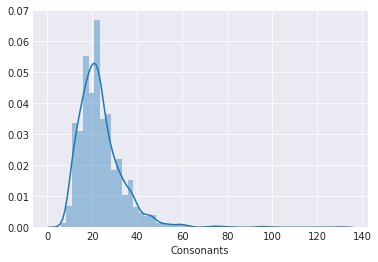

In [11]:
sns.distplot(phoib['Consonants'])

In [13]:
map_with_bins('Consonants', phoib_mapping)

In [14]:
# plotting with bins set on quantiles instead
map_with_bins('Consonants', phoib_mapping, quantiles=True)

### Vowels <a id='vowels'></a>

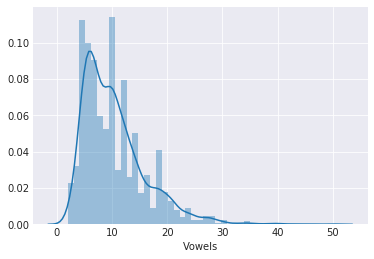

In [15]:
sns.distplot(phoib['Vowels'])

In [16]:
map_with_bins('Vowels', phoib_mapping, quantiles=True)

### Phonemes <a id='phonemes'></a>

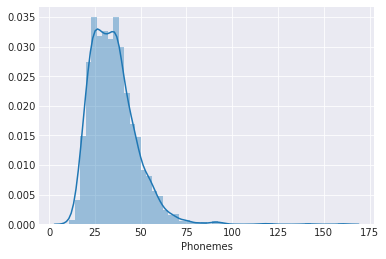

In [17]:
sns.distplot(phoib['Phonemes'])

In [18]:
map_with_bins('Phonemes', phoib_mapping, quantiles=True)

### Consonants vs Vowels <a id='cons vs vows'></a>

Visualize the relationship between number of consontants and number of vowels, again by all language, by continent and by genetic affiliation.

In [58]:
# note to self: check out consonant to vowel ratio as number of cons / vowels increase

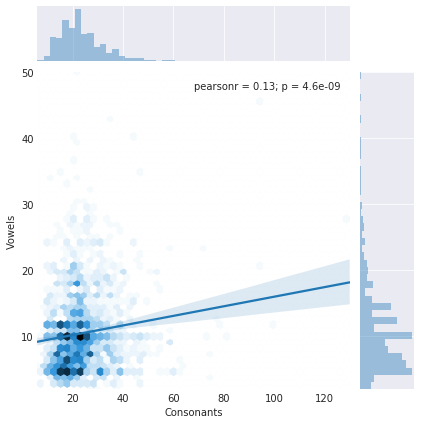

In [61]:
overlay_hex(phoib["Consonants"], phoib["Vowels"])

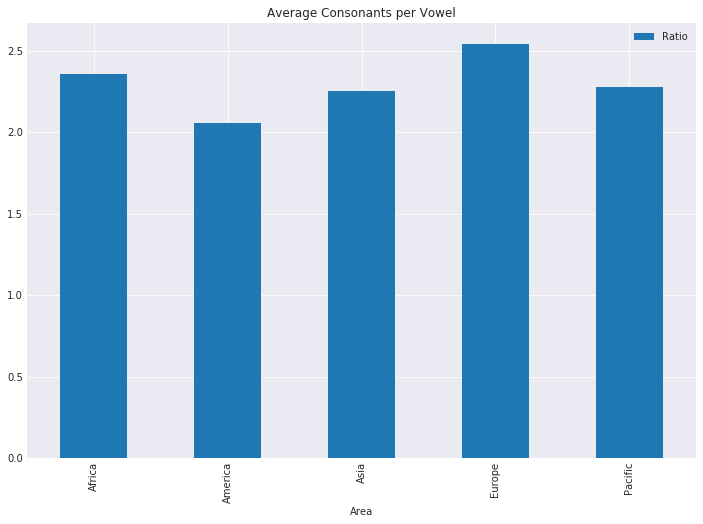

In [63]:
pho_cont = phoib[["Area","Consonants", "Vowels"]].copy()
pho_cont = pho_cont.groupby(by="Area").mean()
pho_cont['Ratio'] = pho_cont['Consonants'] / pho_cont['Vowels']
pho_cont[['Ratio']].plot.bar(figsize = (12,8))
plt.title('Average Consonants per Vowel')

## Phoneme Metadata <a id='metadata'></a>

### By Family  <a id='phoneme fam'></a>

Visualize those same distributions grouped by continent and grouped by genetic affiliation. The continent is called `area` in PHOIBLE. The genetic affiliation is called `Family` in WALS. WALS and PHOIBLE both identify languages with ISO 639-3, so you should be able to match them up. 

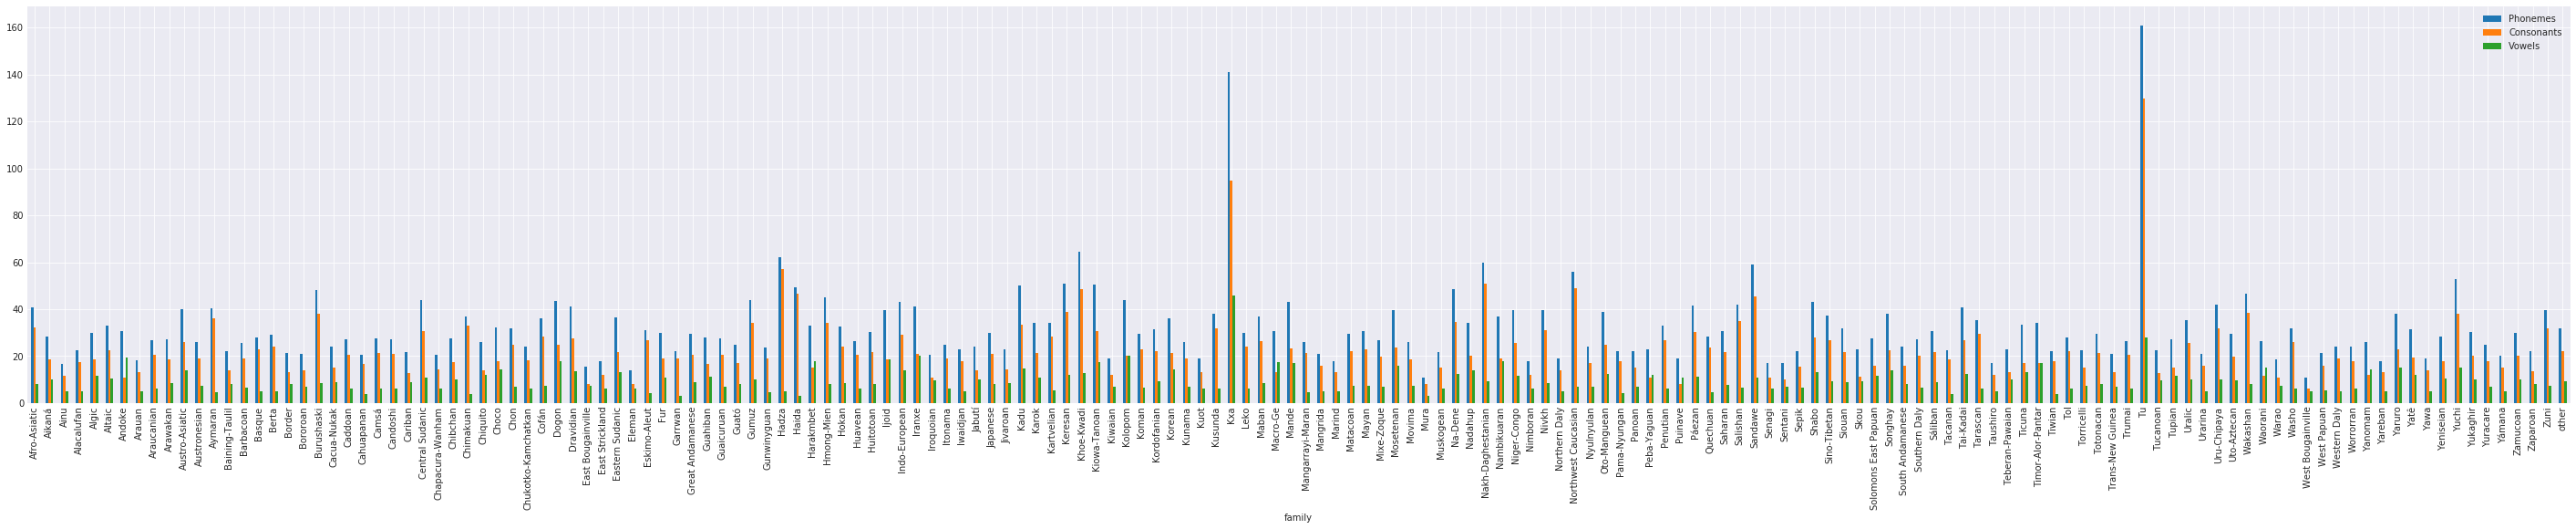

In [54]:
# double click on the image to zoom in (then you can scroll left or right)
combined.groupby(by="family")[['Phonemes', 'Consonants', 'Vowels']].mean().plot.bar(figsize=(50,8))

### By Continent  <a id='phoneme cont'></a>

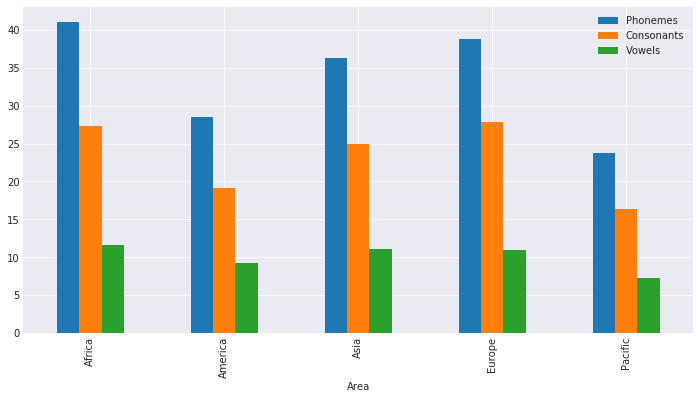

In [66]:
phoib.groupby(by="Area")[['Phonemes', 'Consonants', 'Vowels']].mean().plot.bar(figsize=(12,6))

### Latitude and Longitude <a id='lat lons'></a>

You could try looking at number of phonemes plotted against latitude/longitude, but I doubt anything will come of it.

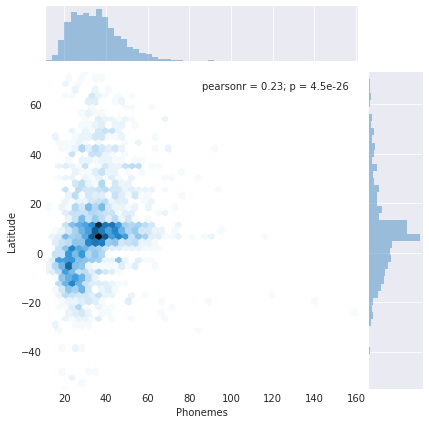

In [65]:
sns.jointplot('Phonemes', 'Latitude', data=phoib, kind='hex')

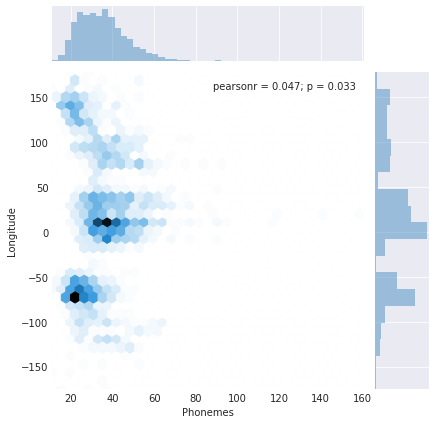

In [64]:
sns.jointplot('Phonemes', 'Longitude', data=phoib, kind='hex')

### Population Size vs Phoneme Inventory Size <a id='pop v foam'></a>

Visualize the relationship between population size and phoneme inventory size, again by all language, by continent and by genetic affiliation.

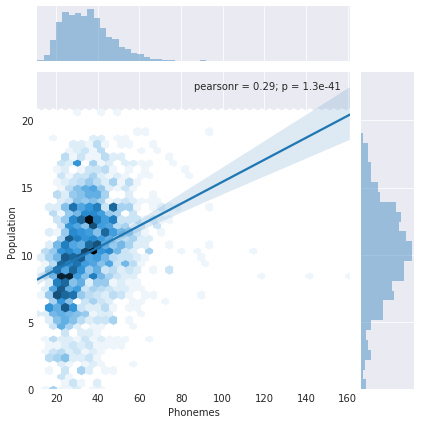

In [29]:
# log population
overlay_hex(phoib["Phonemes"], np.log(phoib["Population"]))

### Distance from Africa <a id='africa distance'></a>

Someone has claimed that phoneme inventory size and distance from Africa are inversely related. You could use the latitude/longitude in PHOIBLE for this. You may have to arbitrarily choose the mid-point of Africa for this.

We start by refering back to a graph we previously created.

Phonemes
Area              
Africa   40.984988
Europe   38.782609
Asia     36.252660
America  28.490939
Pacific  23.741497

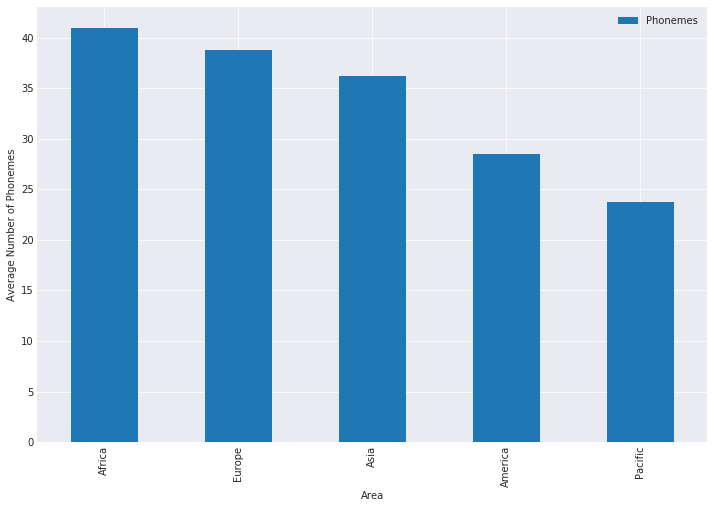

In [69]:
pho_pop_cont = phoib.loc[:,["Area", "Phonemes"]]
pho_pop_cont = pho_pop_cont.groupby(by = "Area").mean().sort_values('Phonemes', ascending=False)
pho_pop_cont[['Phonemes']].plot.bar(figsize = (12,8))
plt.ylabel('Average Number of Phonemes')
pho_pop_cont

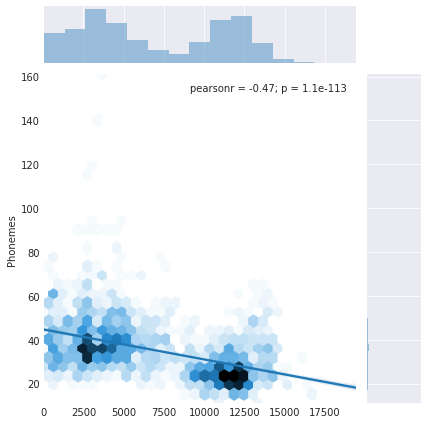

In [30]:
coordinates = list(zip(phoib.dropna()['Latitude'], phoib.dropna()['Longitude']))

# chose this point b/c it comes up when
# you google search 'africa coordinates'
africa_center = (8.7832, 34.5085)

# calculate the distance to each language's listed location
distances = np.array([geopy.distance.vincenty(point, africa_center).km for point in coordinates])

overlay_hex(distances, phoib.dropna()['Phonemes'])

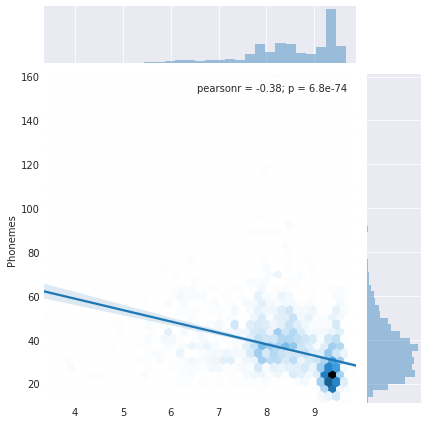

In [31]:
# did the same, but logged the distances this time
overlay_hex(np.log(distances), phoib.dropna()['Phonemes'])

## Common Phenomes <a id='common'></a>

What are the most common phonemes in the world? What is the distribution of frequency? That is, there are about 2,000 phonemes in PHOIBLE, but only a handful are common and there's a long tail. One problem here is that PHOIBLE is not a random sample of languages. So, you could sample languages from PHOIBLE proportional to their population size and arrive at an estimate that way.

Phonemes can be described by a set of (mostly) binary features. PHOIBLE has this data too. Is the distribution of featue values evenly split for each feature? If not, which features are more prone to being either 0 or 1?
Are some phonemes only present in some area of genetic affiliation? (There should be. For example, 'kp' and 'gb' are likely only in Africa.)

## Tone <a id='tone'></a>

One of the features of phonemes is tone. If a language has a phoneme with tone, it counts as a "tone language". Are most language tone? Where are the tone langauges on the map?

In [33]:
tone_languages = phoib['Tones'] > 0
num_tone_languages = sum(tone_languages)
total_languages = len(phoib)

print('There are {} tone languages out of our dataset of {} languages.'.format(num_tone_languages, total_languages))
print("That's about {}%.".format(np.round(num_tone_languages/total_languages*100, 2)))

There are 590 tone languages out of our dataset of 2088 languages.
That's about 28.26%.


In [34]:
tone = phoib[tone_languages]
tone.head()

InventoryID Source LanguageCode      LanguageName Glottocode  \
5             6    SPA          bsk        Burushaski   buru1296   
14           15    SPA          vie        Vietnamese   viet1252   
15           16    SPA          cmn  Mandarin Chinese   mand1415   
16           17    SPA          wuu                Wu   wuch1236   
17           18    SPA          hak             Hakka   hakk1236   

       GlottologName  Trump LanguageFamilyRoot LanguageFamilyGenus   Country  \
5         Burushaski      1               asis          Burushaski  Pakistan   
14        Vietnamese      1               ausa          Viet-Muong  Viet Nam   
15  Mandarin Chinese      2               sitb             Chinese     China   
16        Wu Chinese      1               sitb             Chinese     China   
17     Hakka Chinese      1               sitb             Chinese     China   

    Area  Population  Latitude  Longitude  Phonemes  Consonants  Tones  \
5   Asia       87000   36.2161    74.8236        53          38      3   
14  Asia    65800000   18.3887   106.7570        39          21      6   
15  Asia   840000000   40.0209   116.2280        43          27      4   
16  Asia    77200000   29.8621   119.6820        41          29      3   
17  Asia    25700000   25.0000   116.0000        31          21      4   

    Vowels    elevation  
5       12  3413.164062  
14      12   -53.336613  
15      12    53.678146  
16       9   119.777588  
17       6   404.901245

In [35]:
# two rows in tone don't have coordinates, need to filter them out
valid_coords = tone['Latitude'] == tone['Latitude']
mappable_tone = tone[valid_coords]

mp = folium.Map(zoom_start=12)
for coords in list(zip(mappable_tone['Latitude'], mappable_tone['Longitude'])):
    folium.Circle(
        radius=100,
        location=coords,
        color='crimson',
        fill=False,).add_to(mp)
mp

### Altitude <a id='altitude'></a>

Someone has claimed there is a relationship being a tone language and the altitude. You could use lat/long to call some API to get the altitude and see if there's a relationship.

In [36]:
phoib['Tone Language?'] = phoib['Tones'] > 0
have_elevation = phoib[['elevation', 'Tones', 'Tone Language?']].dropna()

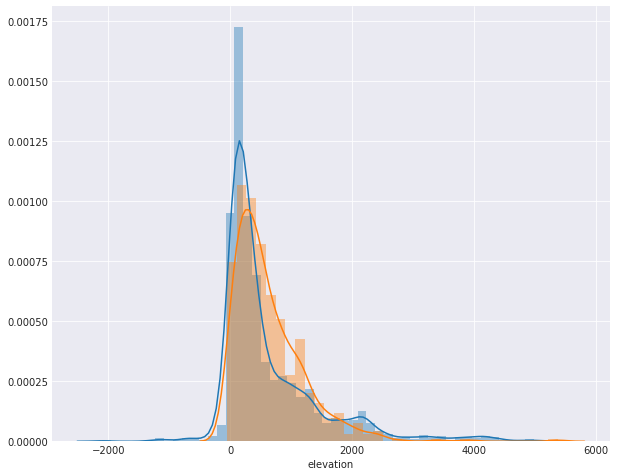

In [37]:
f, ax = plt.subplots(figsize=(10, 8))
sns.distplot(have_elevation[np.invert(have_elevation['Tone Language?'])]['elevation'], ax=ax)
sns.distplot(have_elevation[have_elevation['Tone Language?']]['elevation'], ax=ax)

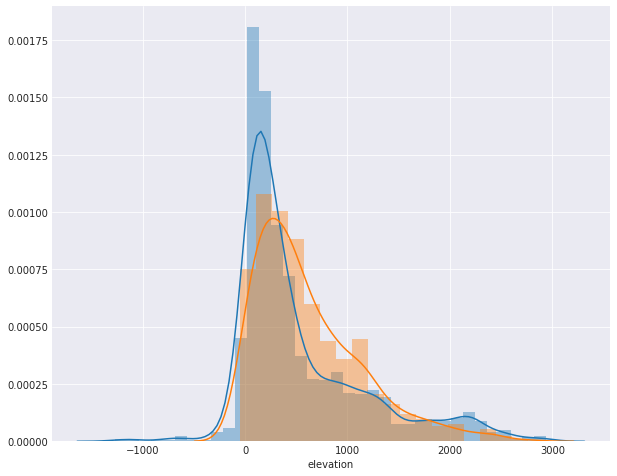

In [38]:
# getting rid of the 3 SD outliers to get a better picture
no_out=have_elevation[((have_elevation['elevation'] - have_elevation['elevation'].mean()) / have_elevation['elevation'].std()).abs() < 3]

f, ax = plt.subplots(figsize=(10, 8))
sns.distplot(no_out[np.invert(no_out['Tone Language?'])]['elevation'], ax=ax)
sns.distplot(no_out[no_out['Tone Language?']]['elevation'], ax=ax)

In [ ]:
# note to self: explore possibility that low elevation 
# places just tend to be further from africa, then point 
# that out as a possible confounding factor

## Relationship between population size and morphological complexity <a id='morph complex'></a>

All the data for this will be in WALS. Morphological complexity is a vague term, referring to how complicated the words in a language are. Here are some features that you should look at with respect to their relation to phoneme inventory size:

### Feature 30A: Number of Genders

In [128]:
desired_columns = ['LanguageCode', 'Area', 'Latitude', 'Longitude', 'Population', 'Phonemes']

gender_data = drop_and_subset('30A Number of Genders', combined, desired_columns)
genders_dict = {'1 None':1, '2 Two':2, '3 Three':3, '4 Four':4, '5 Five or more':5}
gender_data['Genders'] = [genders_dict[value] for value in gender_data['30A Number of Genders']]

print('Rows with Gender data: {}'.format(len(gender_data)))
gender_data.head()

Rows with Gender data: 289


LanguageCode     Area  Latitude  Longitude  Population  Phonemes  \
6           arv   Africa   4.92183    36.7986        4440        59   
13          kjq  America  34.97330  -107.5170        3390        51   
24          ale  America  52.12280  -174.2900         300        36   
25          ale  America  52.12280  -174.2900         300        27   
26          arz   Africa  31.00000    31.0000    52500000        67   

   30A Number of Genders  Genders  
6                  2 Two        2  
13                1 None        1  
24                1 None        1  
25                1 None        1  
26                 2 Two        2

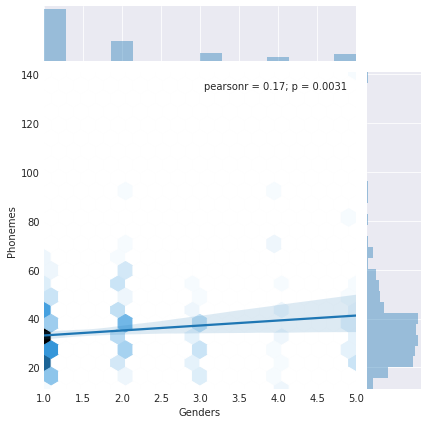

In [129]:
overlay_hex(gender_data['Genders'], gender_data['Phonemes'])

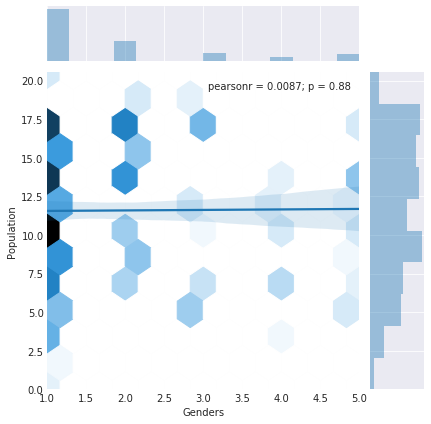

In [130]:
overlay_hex(gender_data['Genders'], np.log(gender_data['Population']))

### Reduplication

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

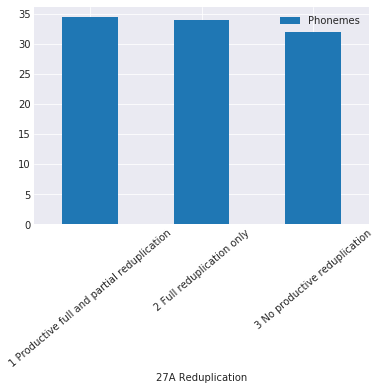

In [152]:
reduplication = drop_and_subset('27A Reduplication', combined, desired_columns)
reduplication.groupby('27A Reduplication').mean()[['Phonemes']].plot.bar()
plt.xticks(rotation=40)

### Feature 20A: Fusion of Selected Inflectional Formatives

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

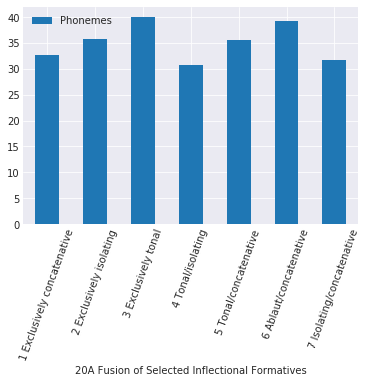

In [153]:
fusion = drop_and_subset('20A Fusion of Selected Inflectional Formatives', combined, desired_columns)
fusion.groupby('20A Fusion of Selected Inflectional Formatives').mean()[['Phonemes']].plot.bar()
plt.xticks(rotation=70)

### Feature 21A: Exponence of Selected Inflectional Formatives

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

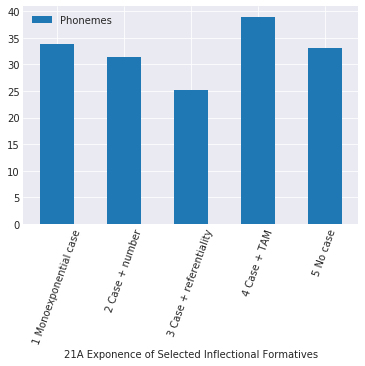

In [154]:
exponence_a = drop_and_subset('21A Exponence of Selected Inflectional Formatives', combined, desired_columns)
exponence_a.groupby('21A Exponence of Selected Inflectional Formatives').mean()[['Phonemes']].plot.bar()
plt.xticks(rotation=70)

### Feature 21B: Exponence of Tense-Aspect-Mood Inflection

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

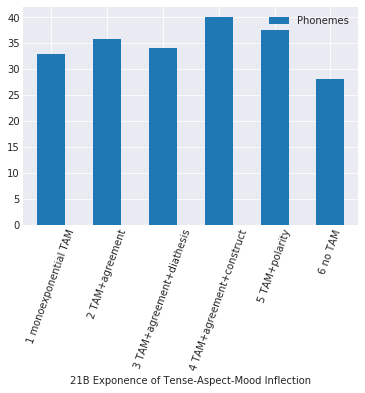

In [155]:
exponence_b = drop_and_subset('21B Exponence of Tense-Aspect-Mood Inflection', combined, desired_columns)
exponence_b.groupby('21B Exponence of Tense-Aspect-Mood Inflection').mean()[['Phonemes']].plot.bar()
plt.xticks(rotation=70)